<h1>Dask dataframe</h1>
<h3>Data Prep</h3>

In [1]:
# %run prep_data.py -d flights

In [17]:
import os
files = os.path.join('data', 'nycflights', '*.csv')
files

'data/nycflights/*.csv'

In [18]:
import dask.dataframe as dd

ddf = dd.read_csv(files,
                  dtype={"TailNum": str,
                        "CRSElapsedTime": float,
                        "Cancelled": bool,
                        "DepDelay": float})
ddf

/usr/local/python/3.12.1/lib/python3.12/site-packages/dask/dataframe/io/csv.py:640: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,string,int64,string,float64,float64,float64,float64,float64,string,string,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
ddf.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [20]:
ddf.dtypes

Date                  datetime64[ns]
DayOfWeek                      int64
DepTime                      float64
CRSDepTime                     int64
ArrTime                      float64
CRSArrTime                     int64
UniqueCarrier        string[pyarrow]
FlightNum                      int64
TailNum              string[pyarrow]
ActualElapsedTime            float64
CRSElapsedTime               float64
AirTime                      float64
ArrDelay                     float64
DepDelay                     float64
Origin               string[pyarrow]
Dest                 string[pyarrow]
Distance                     float64
TaxiIn                       float64
TaxiOut                      float64
Cancelled                       bool
Diverted                       int64
dtype: object

In [21]:
ddf.npartitions

10

<h3>Pandas vs Dask</h3> Speed comparison

In [22]:
max_delay = ddf['DepDelay'].max()

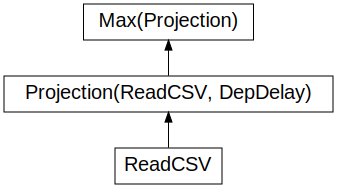

In [23]:
max_delay.visualize()

In [33]:
ddf.isna().sum().compute()

Date                       0
DayOfWeek                  0
DepTime                70931
CRSDepTime                 0
ArrTime                78210
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum              1313006
ActualElapsedTime      78210
CRSElapsedTime          1965
AirTime              1356823
ArrDelay               78210
DepDelay                   0
Origin                     0
Dest                       0
Distance                1495
TaxiIn               1313006
TaxiOut              1313006
Cancelled                  0
Diverted                   0
dtype: int64

In [38]:
ddf['DepDelay'] = ddf['DepDelay'].fillna(0)
max_delay = ddf['DepDelay'].max()

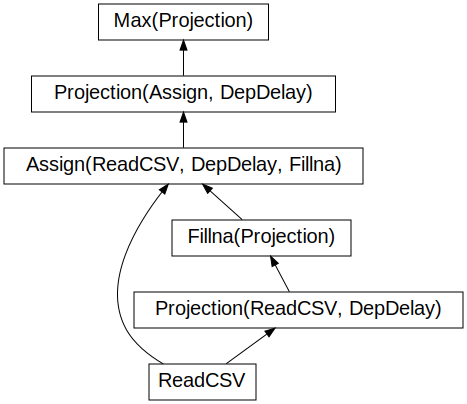

In [40]:
max_delay.visualize()

In [41]:
%%time
max_delay.compute()

CPU times: user 1.72 s, sys: 101 ms, total: 1.82 s
Wall time: 4.31 s


np.float64(1435.0)

In [42]:
%%time
# Pandas code to find maximum delay of files
import pandas as pd

files = os.listdir(os.path.join('data', 'nycflights'))

maxes = []

for file in files:
    df = pd.read_csv(os.path.join('data', 'nycflights', file))
    maxes.append(df.DepDelay.max())

final_max = max(maxes)

CPU times: user 2.57 s, sys: 180 ms, total: 2.75 s
Wall time: 4.06 s


In [43]:
final_max

np.float64(1435.0)